## Loading libraries

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
from matplotlib import *
import scipy
from numpy import linalg as LA
from sklearn.decomposition import PCA
%matplotlib inline


In [27]:
# # Fiddle with figure settings here:
# plt.rcParams['figure.figsize'] = (10,8)
# plt.rcParams['font.weight'] = 'bold'
# plt.rcParams['font.size'] = 10
# plt.rcParams['image.cmap'] = 'seismic'
# plt.rcParams['axes.linewidth'] = 2
# # Set the default colour cycle (in case someone changes it...)
# from cycler import cycler
# cols = plt.get_cmap('tab10').colors
# plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

## "Guide to Emperical orthogonal Functions" ##

1 . EOF analysis using SVD
2.  EOF analysis using Covariance matrix
3.  Rotated EOF analysis



## EOF analysis / Principal Component Analysis (PCA) through SVD

In [28]:
#********************************************************************************************************
### Z= M X  N
### where M is time steps
### where N is Variables
## PYTHON code

def eoffast_svd(matrix,scale,plot):
    # Compute all EOF of matrix  (MXN) and expand it for nmode modes
    # Also returns nproj projection coefficients Z.T = N X M
    ny           =  matrix.shape[0]
    mat          =  np.matrix(matrix)
    mean         =  mat.mean(0)
    std          =  mat.std(0)
    one          =  np.matrix(np.ones(ny,float))
    mean_matrix  =  one.T*mean
    std_matrix   =  one.T*std
    anomaly11    =  mat-mean_matrix            ## Anomaly at each space points
    anomaly22    =  anomaly11/std              ## standarized anomaly at each space points
    
    if scale:
        z        =  anomaly22                  ## SVD on only anomaly matrix (not scaled)
    else:
        z        =  anomaly11
            
    uu, ss, vv   = np.linalg.svd(z.T)  ## uu(N X N) ss(N X N) vv(M X M)
    ## Memory saving decomposition
    lam1         = np.diag(np.square(ss))/np.sum(np.diag(np.square(ss))); #% Explained variances
    lam          = np.diag(lam1)
    ss1          = np.diag(ss)
    vv1          = vv.T[:,0:z.shape[1]]
    uu1          = uu[:,0:z.shape[1]]
    proj         = np.matmul(vv.T[:,0:z.shape[1]],ss1) ## uu(N X N) ss(N X N) vv(M X M)
    eofs         = uu1
    pcs          = proj
    if plot:
        fig, axes = plt.subplots(nrows=3, ncols=3)

        axes[0,0].imshow(matrix)
        axes[0,0].title.set_text("%d(time) X %d (space)" %(matrix.shape[0],matrix.shape[1]))

        ## plot the uu ##
        axes[0,1].imshow(uu)
        axes[0,1].title.set_text("U (%d X %d) space" %(uu.shape[0],uu.shape[1]))

        ## plot the uu1 ##
        axes[0,2].imshow(eofs)
        axes[0,2].title.set_text("uu1 (space eofs) (%d X %d)" %(eofs.shape[0],eofs.shape[1]))

        ## plot the lam ##
        axes[1,0].imshow(ss1)
        axes[1,0].title.set_text("singular values(%d X %d)" %(ss1.shape[0],ss1.shape[1]))

        ## plot the vv
        axes[1,1].imshow(vv)
        axes[1,1].title.set_text("V (%d X %d) time" %(vv.shape[0],vv.shape[1]))

        ## plot the vv1
        axes[1,2].imshow(pcs)
        axes[1,2].title.set_text("PCs (%d X %d) " %(pcs.shape[0],pcs.shape[1]))

        ## plot POV ###
        axes[2,0].bar(np.arange(lam.size),lam)
        axes[2,0].title.set_text("POV ")

        ## plot POV ###
        axes[2,1].bar(np.arange(lam.size),np.squeeze(np.asarray(eofs[:,0])))
        axes[2,1].title.set_text("EOF1 ")

        ## plot POV ###
        axes[2,2].plot(pcs[:,0])
        axes[2,2].title.set_text("PC1 ") 
        
    return eofs,lam,pcs,uu,ss1,vv,lam1

## EOF analysis / Principal Component Analysis (PCA) through Covariance Matrix

In [31]:
def eof_wrap_cov(matrix,scale,plot):
    
    ny            =     matrix.shape[0]
    mat           =     np.matrix(matrix)
    mean          =     mat.mean(0)
    std           =     mat.std(0)
    one           =     np.matrix(np.ones(ny,float))
    mean_matrix   =     one.T*mean
    std_matrix    =     one.T*std
    anomaly11     =     mat-mean_matrix
    anomaly22     =     anomaly11/std
    
    if scale:
        z         =  anomaly22                  ## SVD on only anomaly matrix (not scaled)
    else:
        z         =     anomaly11
        
    cov_matrix    =     z.T*z
    D,V           =     LA.eig(cov_matrix)
    varex         =     D/np.sum(D)
    D1            =     np.diag(D)
    varex_new     =     np.sort(varex)[::-1]
    arg_new       =     np.argsort(varex)[::-1]
    eofs          =     V[:,arg_new]
    pcs          =      z*eofs


    if plot:
        fig, axes = plt.subplots(nrows=4, ncols=2)

        axes[0,0].imshow(matrix)
        axes[0,0].title.set_text("%d(time) X %d (space)" %(matrix.shape[0],matrix.shape[1]))

        ## plot the uu ##
        axes[0,1].imshow(anomaly11)
        axes[0,1].title.set_text("anomaly11(%d X %d) space" %(anomaly11.shape[0],anomaly11.shape[1]))

        ## plot the uu1 ##
        axes[1,0].imshow(cov_matrix)
        axes[1,0].title.set_text("cov_matrix (%d X %d)" %(cov_matrix.shape[0],cov_matrix.shape[1]))

        ## plot the lam ##
        axes[1,1].imshow(D1)
        axes[1,1].title.set_text("Diagonal matrix (%d X %d)" %(D1.shape[0],D1.shape[1]))

        ## plot the vv
        axes[2,0].imshow(V)
        axes[2,0].title.set_text("V (%d X %d) eofs" %(V.shape[0],V.shape[1]))

        ## plot POV ###
        axes[2,1].bar(np.arange(varex_new.size),varex_new)
        axes[2,1].title.set_text("POV ")

        ## plot POV ###
        axes[3,0].bar(np.arange(eofs.shape[0]),np.squeeze(np.asarray(eofs[:,0])))
        axes[3,0].title.set_text("EOF1 ")

        ## plot POV ###
        axes[3,1].plot(pcs[:,0])
        axes[3,1].title.set_text("PC1 ") 
    
    return anomaly11,eofs,pcs,varex_new

## Example a be a matrix with M observation and N points

In [29]:
##  EXAMPLE DATA ###
rand = np.random.randn(50, 8) 

### EOF through SVD

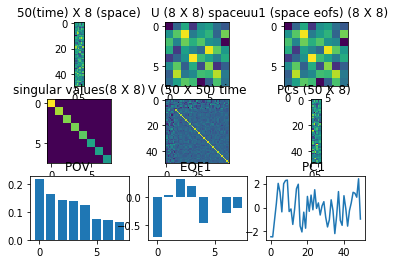

In [30]:
#### PLOT ##############
eofs,lam,pcs,uu,ss1,vv,lam1=eoffast_svd(rand,scale=False,plot=True)
# plt.plot(pcs[:,0])

### EOF through COV matrix

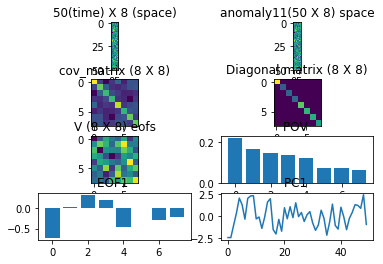

In [32]:
####### PLOT ####################
anomaly11,eofs,pcs,varex_new=eof_wrap_cov(rand,scale=False,plot=True)
# plt.plot(pcs[:,0])

## Rotated EOFs / Rotated PCA using normal VARIMAX ###

In [33]:
def eofrot_normal_varimax(z,ind,index,scale):
    # Algorithm for eof rotation with the varimax method
    # Inputs:
    # z                                                           Data Matrix
    # ind                                                         Index for domain
    # index                                                       indeces of EOFs to be rotated
    # Outputs:
    # coef                                                        Cofficient for the rotated EOFs
    # u                                                           Rotated Eof in ascending order
    # varrotated                                                  Variance explained by rotated EOFs
    
    
    # Compute all EOF of matrix  (MXN) and expand it for nmode modes
    # Also returns nproj projection coefficients Z.T = N X M
    ny           =  matrix.shape[0]
    mat          =  np.matrix(matrix)
    mean         =  mat.mean(0)
    std          =  mat.std(0)
    one          =  np.matrix(np.ones(ny,float))
    mean_matrix  =  one.T*mean
    std_matrix   =  one.T*std
    anomaly11    =  mat-mean_matrix                         # Anomaly at each space points
    anomaly22    =  anomaly11/std                           # standarized anomaly at each space points

    if scale:
        z        =  anomaly22                               # SVD on only anomaly matrix (not scaled)
    else:
        z        =  anomaly11

    
    
    z1=z.T

    uneof,ss,vneof  =  np.linalg.svd(z1)                    # uu(N X N) ss(N X N) vv(M X M)
    npoints,ntime   =  np.shape(z1);                         # Time and space points 
    totvar          =  np.sum(np.diag(np.square(ss)))        # Unrotated EOF for variance
    lding           =  uneof[:,index];  

    sl              = np.square(ss[index]);                             
    varexpl         = np.sum(sl)/totvar;                        #  Relative variance explained by the unrotated modes 
    [n,nf]=np.shape(lding);

    ##
    # b=lding*1;

    hl=lding*(np.diag(sl))
    hjsq=np.diag(hl*hl.T)
    hj=np.sqrt(hjsq)                                               # %Normalize by the communalities

    bh=lding/(np.asmatrix(hj).T*np.ones((1,nf)));

    Vtemp=n*np.sum(np.sum(np.power(bh,4),axis=0))-np.sum(np.square(np.sum(np.square(bh),axis=0)));       
    #Vtemp=n*sum(sum(bh.ˆ4))-sum(sum(bh.ˆ2).ˆ2);                    % VARIMAX functional

    # % VARIMAX functional
                       # % VARIMAX functional
    # np.sum(np.square(np.sum(np.square(bh),axis=0)))

    V0=Vtemp*1
    lding1=np.asarray(lding)
    b=lding1*1

    for it in range(10):                                          #% Number of iterations
        for i in np.arange(nf-1):                                               #  % Program cycles through 2 factors
            for j in np.arange(i+1,nf):

                xj=np.divide(lding1[:,i],hj)                                             #% notation here closely
                yj=np.divide(lding1[:,j],hj)
                uj=np.multiply(xj,xj)-np.multiply(yj,yj)
                vj=2*np.multiply(xj,yj)
                A=np.sum(uj);
                B=np.sum(vj); C=np.sum(uj.T*uj-vj.T*vj)
                D=2*np.sum(uj.T*vj);
                num=D-2*A*B/n;
                den=C-(np.square(A)-np.square(B))/n;
                tan4p=num/den;
                phi=np.arctan2(num,den)/4; angle=phi*180/np.pi;

                if np.abs(phi)> numpy.finfo(float).eps:
                    Xj=np.multiply(np.cos(phi),xj)+np.multiply(np.sin(phi),yj); Yj=-np.sin(phi)*xj+np.cos(phi)*yj;
                    bj1=np.multiply(Xj,hj);
                    bj2=np.multiply(Yj,hj);
                    b[:,i]=bj1;
                    b[:,j]=bj2;
                    lding1[:,i]=b[:,i];
                    lding1[:,j]=b[:,j];

        lding1=b*1;
        bh=lding1/(np.asmatrix(hj).T*np.ones((1,nf)));
        Vtemp=n*np.sum(np.sum(np.power(bh,4),axis=0))-np.sum(np.square(np.sum(np.square(bh),axis=0)))       
        V=Vtemp
        if abs(V-V0)<.0001:
            break
        else:
            V0=V

        for i in np.arange(nf):                                           #% Reflect vectors with negative sums
            if np.sum(lding1[:,i]) < 0:
                lding1[:,i] = -lding1[:,i];



    Arot=lding1 ;                                           # % rotated eof
    coef=z1.T*Arot[:,0:nf];#% time series for rotated eof
    varex=np.zeros(nf)
    for i in np.arange(nf):
        varex[i] = np.sum(np.var((coef[:,i]*Arot[:,i].T),axis=0,ddof=1)*(ntime-1))



    varexplrot = np.sum(varex)/totvar; zvar=np.sum(np.var(z.T)*(ntime-1));
    I=np.argsort(varex)#% Sort in decreasing order of variance
    varex=np.sort(varex);
    Arot=Arot[:,I];
    Arot = np.fliplr(Arot); varex = np.flipud(varex.T);
    varunrotated = sl/totvar;
    varrotated   = varex/totvar;
    u=np.zeros((np.shape(z1)[0],nf));
    u[ind,0:nf] = Arot[:,0:nf]; 

    
    return coef,u,varrotated,varunrotated,Arot

## Rotated EOFs / Rotated PCA using regular VARIMAX ###

In [34]:
def eof_rot_varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
    from scipy import eye, asarray, dot, sum
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in np.arange(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = np.linalg.svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, np.diag(np.diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    rot_eof = dot(Phi, R)
    return rot_eof

## Example with a MJO matrix data

In [35]:
import scipy.io
a = scipy.io.loadmat('X.mat')
a1=a['X']
a1.shape
# np.savetxt('test.csv', a1, delimiter=',') 
# f = open('file.txt', 'wb')
# for i in range(a1.shape[0]):
#     for j in range(a1.shape[1]):
#         f.write("%3.12f \t" %a1[i,j])
#     f.write("\n")
# f.close()


(35, 8)

### EOF analysis and rotated EOF

<BarContainer object of 8 artists>

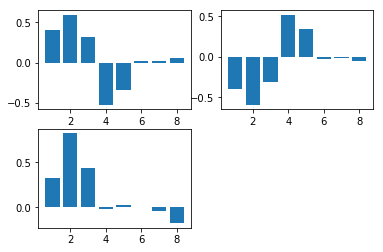

In [46]:
anomaly11,eofs1,pcs,varex_new=eof_wrap_cov(a1,scale=False,plot=False)
eofs2,lam,pcs,uu,ss1,vv,lam1=eoffast_svd(a1,scale=False,plot=False)
rot=eof_rot_varimax(eofs[:,0:5])
plt.subplot(221)
plt.bar(np.arange(1,9,1),np.squeeze(np.asarray(eofs1[:,0])))
plt.subplot(222)
plt.bar(np.arange(1,9,1),np.squeeze(np.asarray(eofs2[:,0])))
plt.subplot(223)
plt.bar(np.arange(1,9,1),np.squeeze(np.asarray(rot[:,0])))

In [60]:
# from factor_analyzer.factor_analyzer import calculate_kmo
# from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
# import pandas as pd
# df= pd.DataFrame(eofs,columns=['EOF1','EOF2','EOF3','EOF4','EOF5','EOF6','EOF7','EOF8'])
# chi_square_value,p_value=calculate_bartlett_sphericity(df)
# chi_square_value, p_value


In [61]:
# from factor_analyzer import FactorAnalyzer,Rotator
# fa = FactorAnalyzer(rotation="varimax")
# fa.fit(df,6)
# rotator = Rotator()
# rotator.fit(fa.loadings_)
# rotator.loadings_